In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score,classification_report,roc_curve, auc, confusion_matrix,precision_recall_curve 
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold 
from sklearn.preprocessing import LabelEncoder
import lime
import lime.lime_tabular
import shap
import time

In [17]:
path = r"C:\Users\Checkout\Desktop\CS267\LC_loan_after_feature_selection.csv" #Use only when running on local
eng_feat = pd.read_csv(path)

In [18]:
eng_feat.drop(columns = ["Unnamed: 0"], inplace = True)

In [19]:
#Fully Paid: 0, Charged Off/Default : 1 (Label: Status, drop loan_status from Training Data)
X = eng_feat
Y = pd.DataFrame(data = eng_feat["Status"], columns = ["Status"])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [21]:
X_test["loan_status"]
X_test["out_prncp"]

305297    0.0
38053     0.0
439867    0.0
155633    0.0
373652    0.0
         ... 
500195    0.0
403413    0.0
39315     0.0
458903    0.0
297812    0.0
Name: out_prncp, Length: 102366, dtype: float64

In [22]:
y_test

Status
305297       0
38053        0
439867       0
155633       1
373652       0
...        ...
500195       0
403413       0
39315        0
458903       0
297812       0

[102366 rows x 1 columns]

In [23]:
X_test

loan_amnt  term  int_rate  loan_status  inq_last_6mths  \
305297      13000     0     15.05   Fully Paid             0.0   
38053       10000     1      8.59   Fully Paid             1.0   
439867      12000     1     12.49   Fully Paid             1.0   
155633      25000     0      9.17  Charged Off             0.0   
373652       7200     1     12.12   Fully Paid             0.0   
...           ...   ...       ...          ...             ...   
500195       4500     1      5.32   Fully Paid             0.0   
403413       7600     1     14.09   Fully Paid             0.0   
39315        9350     1     16.99   Fully Paid             1.0   
458903      15000     0     17.57   Fully Paid             1.0   
297812      10000     1      9.44   Fully Paid             0.0   

        initial_list_status  out_prncp   total_pymnt  total_rec_int  \
305297                    1        0.0  14720.029384        1720.03   
38053                     1        0.0  10275.320000         275.32   
439867                    1        0.0  12977.540000         977.54   
155633                    1        0.0   6239.620000        2109.02   
373652                    0        0.0   8392.509998        1192.51   
...                     ...        ...           ...            ...   
500195                    1        0.0   4646.374476         146.37   
403413                    0        0.0   8467.511306         867.51   
39315                     1        0.0  11893.337885        2543.34   
458903                    1        0.0  19454.670000        4454.67   
297812                    1        0.0  10922.387955         922.39   

        total_rec_late_fee  ...  purpose_debt_consolidation  \
305297                 0.0  ...                           1   
38053                  0.0  ...                           1   
439867                 0.0  ...                           0   
155633                 0.0  ...                           1   
373652                 0.0  ...                           1   
...                    ...  ...                         ...   
500195                 0.0  ...                           0   
403413                 0.0  ...                           1   
39315                  0.0  ...                           1   
458903                 0.0  ...                           0   
297812                 0.0  ...                           0   

        purpose_home_improvement  purpose_house  purpose_major_purchase  \
305297                         0              0                       0   
38053                          0              0                       0   
439867                         0              0                       0   
155633                         0              0                       0   
373652                         0              0                       0   
...                          ...            ...                     ...   
500195                         0              0                       0   
403413                         0              0                       0   
39315                          0              0                       0   
458903                         0              0                       0   
297812                         0              0                       0   

        purpose_medical  purpose_moving  purpose_renewable_energy  \
305297                0               0                         0   
38053                 0               0                         0   
439867                0               0                         0   
155633                0               0                         0   
373652                0               0                         0   
...                 ...             ...                       ...   
500195                0               0                         0   
403413                0               0                         0   
39315                 0               0                         0   
458903        

In [24]:
def get_class_dist(data, name):
    unique, counts = np.unique(data, return_counts=True)
    pct = 100*(counts/len(data))
    d = dict(zip(unique, zip(counts, pct)))
    print(len(data), 'total examples in %s' % name)
    for key, values in d.items():
        print('class %d: %d examples,' % (key, values[0]), "{0:.2f}%".format(values[1]))
    print('')
    return

# Only supports Continuous Features
def oversampling(data, y_label, k = 5, seed = 1):
    
    from imblearn.over_sampling import SMOTE
    X = data.loc[:, data.columns != y_label]
    y = data[y_label]
    sm = SMOTE(sampling_strategy = 'auto', k_neighbors = k, random_state = seed, n_jobs = -1)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

# Supports Categorical and Continuous Features
def oversampling_nc(data, y_label, k = 5, seed = 1, cat_features = [None]):
    
    from imblearn.over_sampling import SMOTENC
    X = data.loc[:, data.columns != y_label]
    y = data[y_label]
    sm = SMOTENC(sampling_strategy = 'auto', k_neighbors = k, random_state = seed, categorical_features = cat_features, n_jobs = -1)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

In [25]:
X_train_smote, y_train_smote = oversampling(X_train.drop(["loan_status"], axis = 1), 'Status')
X_smote = pd.merge(X_train_smote, y_train_smote, left_index = True, right_index = True)
get_class_dist(data=y_train_smote, name='y_train_smote')

713172 total examples in y_train_smote
class 0: 356586 examples, 50.00%
class 1: 356586 examples, 50.00%



In [26]:
X_test.drop(["Status", "loan_status"], axis = 1, inplace = True)
X_train.drop(["Status", "loan_status"], axis = 1, inplace = True)

In [27]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score,classification_report,roc_curve, auc, confusion_matrix,precision_recall_curve 
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

In [28]:
from sklearn.model_selection import KFold 

def model_cross_validation(model,X,y,K):
    X = X.to_numpy()
    y = y.to_numpy()
    kf=KFold(K,shuffle=True)
    folds=list(kf.split(X))
    kfolds=len(folds)
    train_performance=np.empty(kfolds)
    validation_performance=np.empty(kfolds)
    for idx in range(kfolds):
        train,validation=folds[idx] # this give us the indexes of train and validation datapoints in current fold
        X_train=X[train]
        y_train=y[train]
        model.fit(X_train,y_train)
        train_accuracy=np.average(model.predict(X_train)==y_train)
        X_validation=X[validation]
        y_validation=y[validation]
        validation_accuracy=np.average(model.predict(X_validation)==y_validation)
        train_performance[idx]=train_accuracy
        validation_performance[idx]=validation_accuracy
    return train_performance,validation_performance

In [29]:
X_test.columns


Index(['loan_amnt', 'term', 'int_rate', 'inq_last_6mths',
       'initial_list_status', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'delinq_amnt',
       'debt_settlement_flag', 'A', 'B', 'C', 'D', 'home_ownership_RENT',
       'home_ownership_MORTGAGE', 'home_ownership_OWN', 'Not Verified',
       'Source Verified', 'Verified', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_moving', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')

In [30]:
rf_clf = RandomForestClassifier(n_estimators = 500, max_depth = 20,
                                n_jobs = -1)

x_train, y_train = X_train_smote, y_train_smote
rf_clf.fit(x_train.values, y_train)
y_pred = rf_clf.predict(X_test)
print('Confusion Matrix:',confusion_matrix(y_test,y_pred))

Confusion Matrix: [[89137     3]
 [  605 12621]]


In [54]:
print(len(y_pred))
for i in range(len(y_pred)):
    if y_pred[i] == 0:
        print(i)
        print(X_test.iloc[i])
        with open('sk.txt', 'w') as f:
            f.write(str(X_test.iloc[0]))
        break

print(X_test.columns)
print(y_pred)

102366
0
loan_amnt                     13000.000000
term                              0.000000
int_rate                         15.050000
inq_last_6mths                    0.000000
initial_list_status               1.000000
out_prncp                         0.000000
total_pymnt                   14720.029384
total_rec_int                  1720.030000
total_rec_late_fee                0.000000
recoveries                        0.000000
last_pymnt_amnt               11634.700000
delinq_amnt                       0.000000
debt_settlement_flag              1.000000
A                                 0.000000
B                                 0.000000
C                                 1.000000
D                                 0.000000
home_ownership_RENT               1.000000
home_ownership_MORTGAGE           0.000000
home_ownership_OWN                0.000000
Not Verified                      1.000000
Source Verified                   0.000000
Verified                          0.000000
pu

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     89140
           1       1.00      0.95      0.98     13226

    accuracy                           0.99    102366
   macro avg       1.00      0.98      0.99    102366
weighted avg       0.99      0.99      0.99    102366



In [44]:
y_pred_proba = rf_clf.predict_proba(X_test)

In [33]:
#Pickling the model for later use!
filename = 'randomForest_model.pkl'
pickle.dump(rf_clf, open(filename, 'wb'))

In [45]:
# load the model from disk
pickle_path = r"C:\Users\Checkout\Desktop\CS267\randomForest_model.pkl" #Use when running on local
loaded_model_rf = pickle.load(open(pickle_path, 'rb'))
result_class = loaded_model_rf.predict(X_test)
print("Predicted Class: ", result_class)
result_rf = loaded_model_rf.score(X_test, y_test)
print("Accuracy Score: ", result_rf)

Predicted Class:  [0 0 0 ... 0 0 0]
Accuracy Score:  0.9940605279096575


In [25]:
#lime starts below

In [26]:
feature_names = [i for i in X_train_smote.columns]

In [27]:
class_names = np.array(["Fully Paid", "Default/Charged Off"])

In [28]:
predict_fn_rf = lambda x: loaded_model_rf.predict_proba(x).astype(float)

In [29]:
X_train_smote_np = np.array(X_train_smote)

In [30]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_smote_np, feature_names=feature_names, class_names=class_names, discretize_continuous=True)

In [31]:
X_test_np = np.array(X_test)

In [32]:
np.random.seed(1)
i = 100
exp = explainer.explain_instance(X_test_np[i], predict_fn_rf, num_features=10)
exp.show_in_notebook(show_all=False)

print("Ground Truth: ", y_test["Status"].iloc[i])

Ground Truth:  0


In [33]:
i = 5000
exp = explainer.explain_instance(X_test_np[i], predict_fn_rf, num_features=10)
exp.show_in_notebook(show_all=False)
print("Ground Truth: ", y_test["Status"].iloc[i])

Ground Truth:  1


In [34]:
#shap starts below

In [35]:
shap.initjs()

In [36]:
shap_explainer = shap.TreeExplainer(loaded_model_rf)

In [37]:
#Change the size of the explainations to get an idea of the time required to execute
start = time.time()
shap_values_100 = shap_explainer.shap_values(X_train_smote[:100])
end = time.time()
print("Time required to get the SHAP values for 100 entries: ", end-start)

KeyboardInterrupt: 

In [ ]:
#SHAP Values for Both the Classes
for i in shap_values_100:
    print(i.shape)

(100, 35)
(100, 35)


In [ ]:
y_train_smote.head()

0    1
1    1
2    0
3    0
4    0
Name: Status, dtype: int64

In [ ]:
shap.force_plot(shap_explainer.expected_value[1], shap_values_100[0][2,:], X_train_smote[:100].iloc[2,:])

In [ ]:
shap.force_plot(shap_explainer.expected_value[1], shap_values_100[1][2,:], X_train_smote[:100].iloc[2,:])

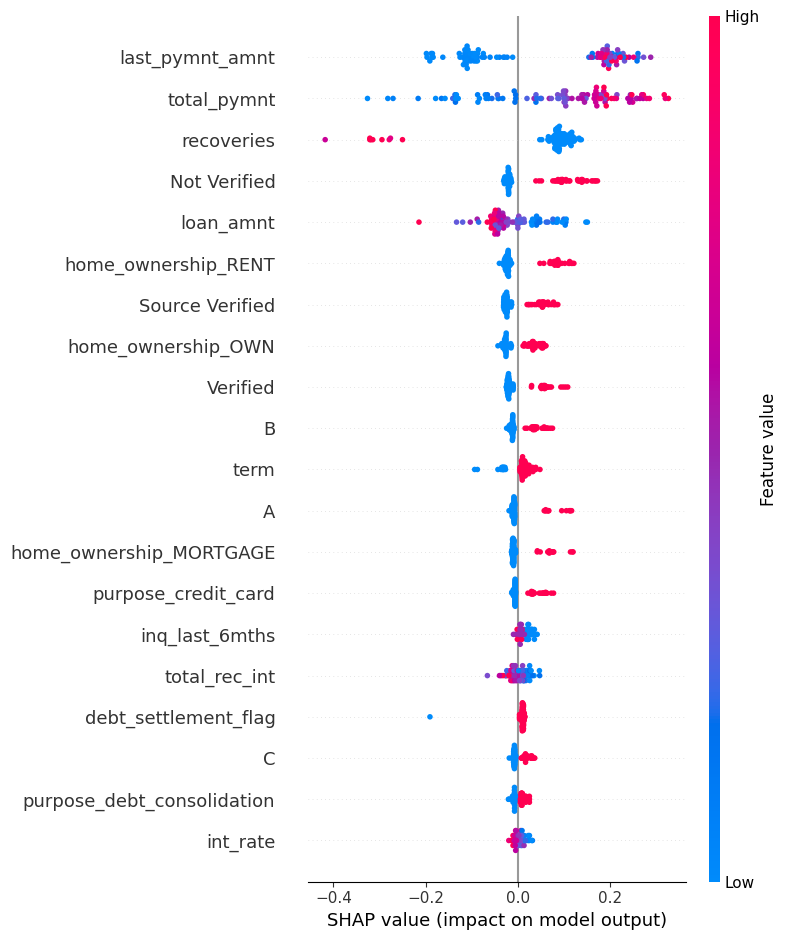

In [ ]:
shap.summary_plot(shap_values_100[0], X_train_smote.iloc[:100, :], plot_type = "dot")

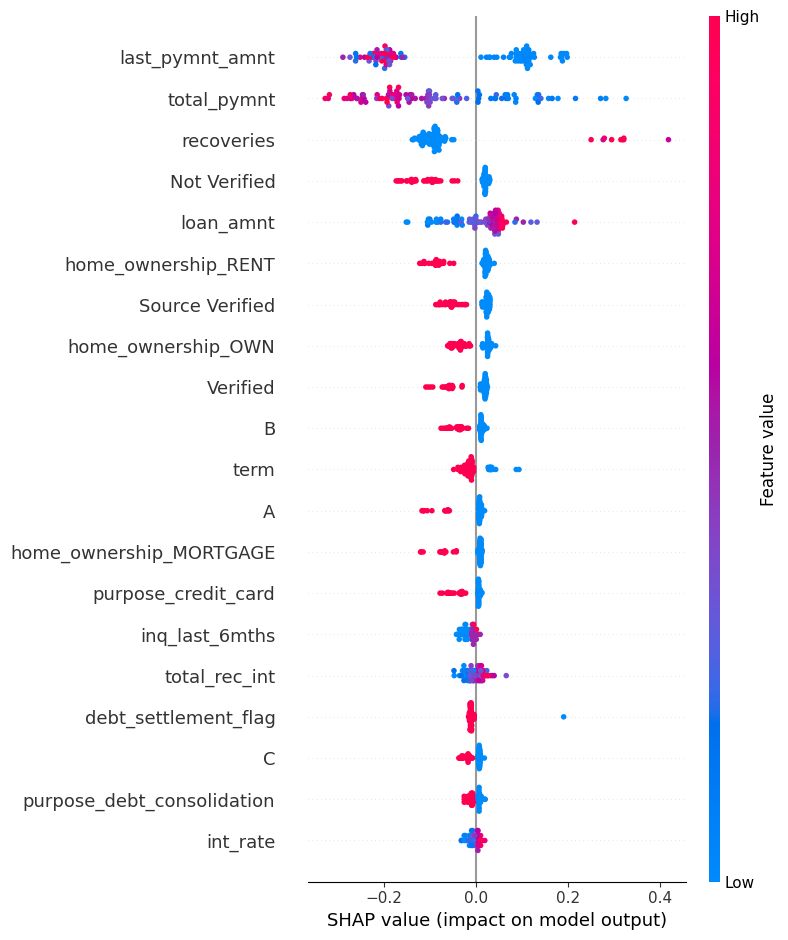

In [ ]:
shap.summary_plot(shap_values_100[1], X_train_smote.iloc[:100, :], plot_type = "dot")

In [ ]:
y_test[:100]["Status"].value_counts()

Status
0    82
1    18
Name: count, dtype: int64

In [ ]:
shap_values_test_100 = shap_explainer.shap_values(X_test.iloc[0:100,:])

In [ ]:
shap.force_plot(shap_explainer.expected_value[1], shap_values_test_100[1][0:100,:], X_test.iloc[0:100,:])

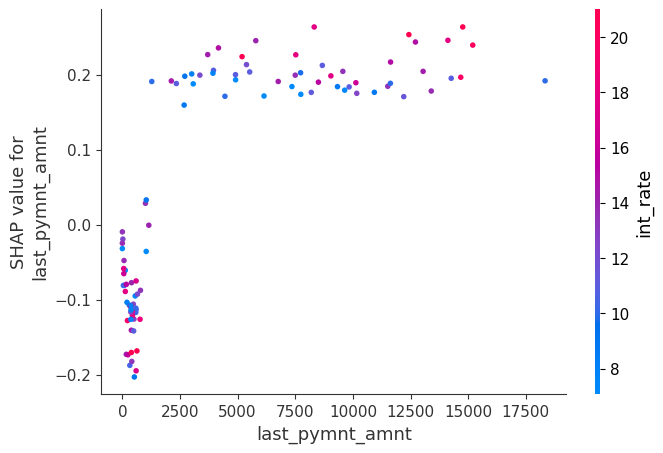

In [ ]:
shap.dependence_plot("last_pymnt_amnt", shap_values_test_100[0], X_test.iloc[0:100,:])

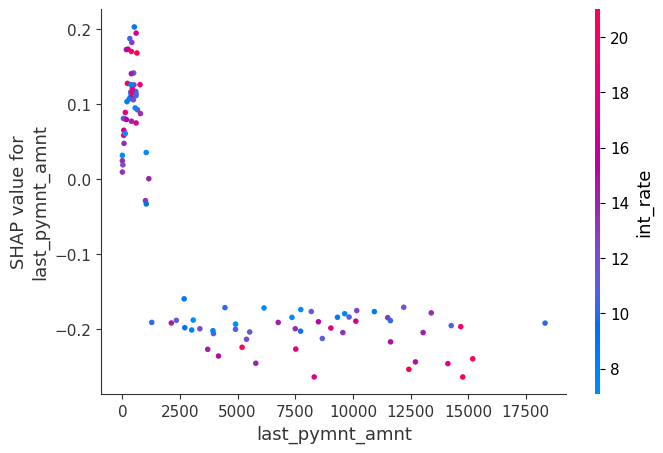

In [ ]:
shap.dependence_plot("last_pymnt_amnt", shap_values_test_100[1], X_test.iloc[0:100,:])

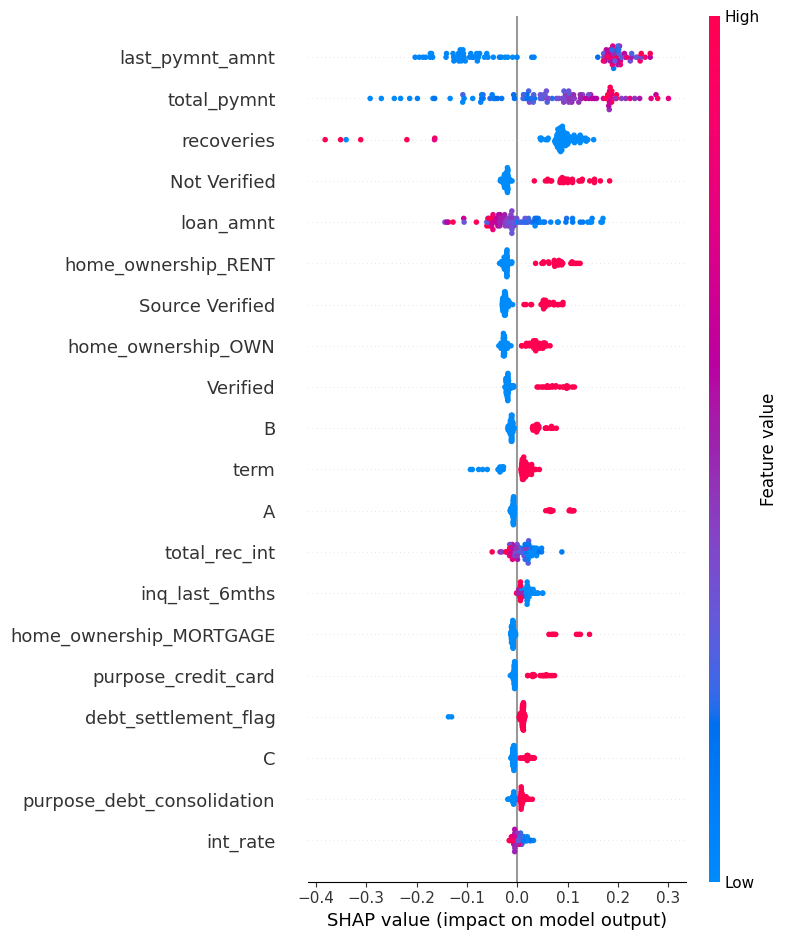

In [ ]:
shap.summary_plot(shap_values_test_100[0], X_test.iloc[:100, :], plot_type = "dot")

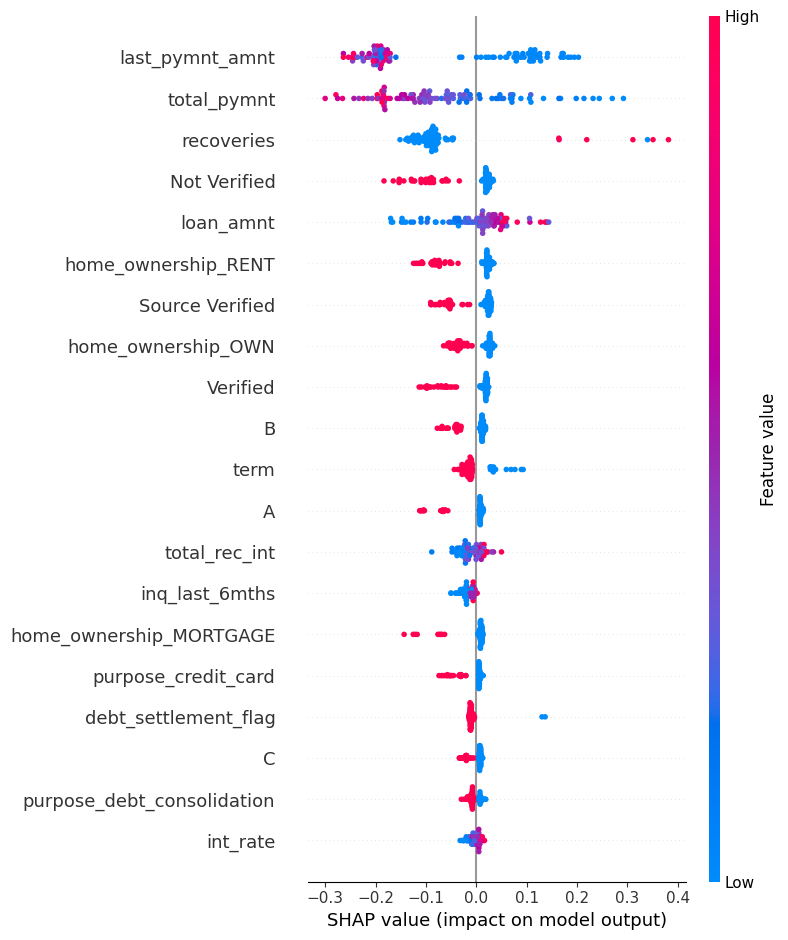

In [ ]:
shap.summary_plot(shap_values_test_100[1], X_test.iloc[:100, :], plot_type = "dot")